In [4]:
from src.utils import audio_utils
import matplotlib.pyplot as plt
import os
import torch
nn = torch.nn
from src.utils import path_utils
import torchinfo
import torchvision
from tqdm import tqdm

In [5]:
class ClassifDataset(torch.utils.data.Dataset):

  def __init__(self, positive_path, negative_path, hard_path, mean, std, transform_audio):
    self.positive_path = positive_path
    self.negative_path = negative_path
    self.hard_path = hard_path
    self.positive_files = [file for file in os.listdir(self.positive_path) if file.endswith(".wav")]
    self.negative_files = [file for file in os.listdir(self.negative_path) if file.endswith(".wav")]
    self.hard_files = [file for file in os.listdir(self.hard_path) if file.endswith(".wav")]
    self.reshape_size = (129, 229)

    self.transform_audio = transform_audio
    self.transform_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize(self.reshape_size),torchvision.transforms.Normalize(mean=mean, std=std)])

  def __len__(self):
    return len(self.positive_files) + len(self.negative_files) + len(self.hard_files)

  def __getitem__(self, idx):
    if idx < len(self.positive_files):
      file_path = os.path.join(self.positive_path, self.positive_files[idx])
      data, fs = audio_utils.load_audio_file(file_path)
      x = self.transform_audio(data)
      x = self.transform_image(x)
      return x, 1
    elif idx < len(self.positive_files) + len(self.negative_files):
      file_path = os.path.join(self.negative_path, self.negative_files[idx - len(self.positive_files)])
      data, fs = audio_utils.load_audio_file(file_path)
      x = self.transform_audio(data)
      x = self.transform_image(x)
      return x, 0
    else:
      file_path = os.path.join(self.hard_path, self.hard_files[idx - len(self.positive_files) - len(self.negative_files)])
      data, fs = audio_utils.load_audio_file(file_path)
      x = self.transform_audio(data)
      x = self.transform_image(x)
      return x, 0

In [6]:
def create_dataset(train_test: bool):

  def transform_audio(data):
    _, _, specto = audio_utils.compute_spectrogram(data, 24000, nperseg=256, noverlap=256//4, scale="dB")
    # freq clip
    specto = specto[:120, :]
    return specto

  dataset = ClassifDataset(
    positive_path=path_utils.get_train_test_path(path_utils.get_positive_samples_path(), train_test),
    negative_path=path_utils.get_train_test_path(path_utils.get_negative_samples_path(), train_test),
    hard_path=path_utils.get_train_test_path(path_utils.get_hard_samples_path(), train_test),
    mean=0.,
    std=1.,
    transform_audio=transform_audio)
  
  return dataset

In [7]:
train_dataset = create_dataset(train_test=True)
test_dataset = create_dataset(train_test=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [8]:
mean, std = 0., 0.
for x, y in train_dataloader:
  mean += torch.mean(x)
  std += torch.std(x, ) ** 2
print(f"mean: {mean/len(train_dataset)}, std: {(std/len(train_dataset)) ** 0.5}")

mean: -1.1142219305038452, std: 1.8928380012512207


In [9]:
def create_dataset_standadization(train_test: bool):

  def transform_audio(data):
    _, _, specto = audio_utils.compute_spectrogram(data, 24000, nperseg=256, noverlap=256//4, scale="dB")
    # freq clip
    specto = specto[:120, :]
    return specto

  dataset = ClassifDataset(
    positive_path=path_utils.get_train_test_path(path_utils.get_positive_samples_path(), train_test),
    negative_path=path_utils.get_train_test_path(path_utils.get_negative_samples_path(), train_test),
    hard_path=path_utils.get_train_test_path(path_utils.get_hard_samples_path(), train_test),
    mean=-1.5489901304244995,
    std=3.3042893409729004,
    transform_audio=transform_audio)
  
  return dataset

In [10]:
train_dataset = create_dataset_standadization(train_test=True)
test_dataset = create_dataset_standadization(train_test=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [11]:
mean, std = 0., 0.
for x, y in train_dataloader:
  mean += torch.mean(x)
  std += torch.std(x, ) ** 2
print(f"mean: {mean/len(train_dataset)}, std: {(std/len(train_dataset)) ** 0.5}")

mean: -0.3224743604660034, std: 0.5711084604263306


In [12]:
class BasicModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linear = nn.Linear(128, 2)
  
  def forward(self, x):
    x = self.main(x)
    # global average pooling
    x = nn.functional.avg_pool2d(x, kernel_size=x.shape[2:]).view(x.shape[0], -1)
    x = self.linear(x)
    return x


In [13]:
model = BasicModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torchinfo.summary(model, input_size=(1, 1, 400, 200))

Layer (type:depth-idx)                   Output Shape              Param #
BasicModel                               [1, 2]                    --
├─Sequential: 1-1                        [1, 128, 25, 12]          --
│    └─Conv2d: 2-1                       [1, 16, 400, 200]         160
│    └─ReLU: 2-2                         [1, 16, 400, 200]         --
│    └─MaxPool2d: 2-3                    [1, 16, 200, 100]         --
│    └─Conv2d: 2-4                       [1, 32, 200, 100]         4,640
│    └─ReLU: 2-5                         [1, 32, 200, 100]         --
│    └─MaxPool2d: 2-6                    [1, 32, 100, 50]          --
│    └─Conv2d: 2-7                       [1, 64, 100, 50]          18,496
│    └─ReLU: 2-8                         [1, 64, 100, 50]          --
│    └─MaxPool2d: 2-9                    [1, 64, 50, 25]           --
│    └─Conv2d: 2-10                      [1, 128, 50, 25]          73,856
│    └─ReLU: 2-11                        [1, 128, 50, 25]          --
│  

In [19]:
for epoch in tqdm(range(10)):
  print("="*30)
  for i, (x, y) in enumerate(train_dataloader):
    loss = loss_fn(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  accu = 0
  loss = 0
  # for i, (x, y) in enumerate(test_dataloader):
  #   logits = model(x)
  #   loss += loss_fn(logits, y)
  #   accu += torch.sum(torch.argmax(logits, dim=1) == y).item()
  # print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, loss / len(test_dataset), accu / len(test_dataset)))

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 10%|█         | 1/10 [00:25<03:52, 25.83s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 20%|██        | 2/10 [00:45<02:56, 22.02s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 30%|███       | 3/10 [01:05<02:29, 21.34s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 40%|████      | 4/10 [01:31<02:18, 23.05s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 50%|█████     | 5/10 [01:49<01:46, 21.21s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 60%|██████    | 6/10 [02:08<01:21, 20.41s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 70%|███████   | 7/10 [02:28<01:00, 20.25s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 80%|████████  | 8/10 [02:45<00:38, 19.34s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


 90%|█████████ | 9/10 [03:08<00:20, 20.52s/it]

torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])
torch.Size([32, 1, 129, 229])


100%|██████████| 10/10 [03:25<00:00, 20.55s/it]


In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

targets = []
predictions = []
for i, (x, y) in enumerate(test_dataloader):
  logits = model(x)
  predictions.extend(torch.argmax(logits, dim=1).numpy().tolist())
  targets.extend(y.numpy().tolist())

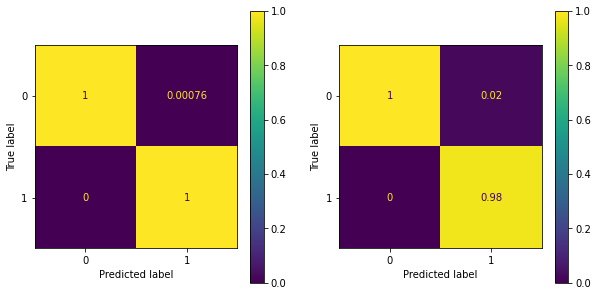

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(targets, predictions, normalize="true", ax=axs[0])
ConfusionMatrixDisplay.from_predictions(targets, predictions, normalize="pred", ax=axs[1])